In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./Building_Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./Building_Dataset/.DS_Store
./Building_Dataset/spalling/cls05_073.jpg
./Building_Dataset/spalling/cls05_318.jpg
./Building_Dataset/spalling/cls05_186.jpg
./Building_Dataset/spalling/cls05_240.jpg
./Building_Dataset/spalling/cls05_291.jpg
./Building_Dataset/spalling/cls05_157.jpg
./Building_Dataset/spalling/cls05_008.jpg
./Building_Dataset/spalling/cls05_181.jpg
./Building_Dataset/spalling/cls05_247.jpg
./Building_Dataset/spalling/cls05_296.jpg
./Building_Dataset/spalling/cls05_150.jpg
./Building_Dataset/spalling/cls05_074.jpg
./Building_Dataset/spalling/cls05_006.jpg
./Building_Dataset/spalling/cls05_311.jpg
./Building_Dataset/spalling/cls05_249.jpg
./Building_Dataset/spalling/cls05_298.jpg
./Building_Dataset/spalling/cls05_235.jpg
./Building_Dataset/spalling/cls05_122.jpg
./Building_Dataset/spalling/cls05_232.jpg
./Building_Dataset/spalling/cls05_125.jpg
./Building_Dataset/spalling/cls05_001.jpg
./Building_Dataset/spalling/cls05_316.jpg
./Building_Dataset/spalling/cls05_188.jpg
./Bui

In [3]:
import os, random, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------------------
# 2. DATASET + BIO MAPPING
# ----------------------------
DATASET_PATH = "./Building_Dataset"

BIO_MAP = {
    "mold": 1,
    "algae": 1,
    "Wall": 0,
    "normal": 0,
    "stain": 0,
    "peeling": 0,
    "spalling": 0,
    "major_crack": 0,
    "minor_crack": 0
}

train_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])



Device: cpu


## Maitri_Shah_Pipeline to build initial Convolutional Nural Network
### Train/val/test with 70/15/15 split
### Custom Dataset class to load images from Building_Dataset with binary labels (mold/algae=1, others=0)
### CNN architecture with 4 convolutional blocks, batch normalization, dropout, and fully connected layers
### Training setup with BCEWithLogitsLoss, Adam optimizer, and learning rate scheduler
### Complete training loop with validation, tracking metrics, and model checkpointing
### Training history visualization (loss and accuracy plots)
### Test set evaluation with accuracy, precision, recall, and F1-score
### Confusion matrix visualization




In [5]:
# ----------------------------
# 3. CUSTOM DATASET CLASS
# ----------------------------
class BuildingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            
            # Get binary label from BIO_MAP
            label = BIO_MAP.get(class_name, 0)
            
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(class_path, img_name))
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load full dataset
full_dataset = BuildingDataset(DATASET_PATH, transform=None)
print(f"Total images: {len(full_dataset)}")
print(f"Labels distribution: Mold={sum(full_dataset.labels)}, Non-mold={len(full_dataset.labels)-sum(full_dataset.labels)}")

Total images: 3925
Labels distribution: Mold=674, Non-mold=3251


In [6]:
# ----------------------------
# 4. SPLIT DATA: 70% TRAIN, 15% VAL, 15% TEST
# ----------------------------
from sklearn.model_selection import train_test_split

indices = list(range(len(full_dataset)))
labels = full_dataset.labels

# First split: 70% train, 30% temp (val+test)
train_idx, temp_idx = train_test_split(
    indices, test_size=0.3, random_state=SEED, stratify=labels
)

# Second split: split temp into 50-50 (15% val, 15% test)
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, random_state=SEED, stratify=temp_labels
)

print(f"Train set: {len(train_idx)} images")
print(f"Val set: {len(val_idx)} images")
print(f"Test set: {len(test_idx)} images")

# Create datasets with appropriate transforms
train_dataset = BuildingDataset(DATASET_PATH, transform=train_tfms)
val_dataset = BuildingDataset(DATASET_PATH, transform=val_tfms)
test_dataset = BuildingDataset(DATASET_PATH, transform=val_tfms)

# Create subset datasets
train_data = Subset(train_dataset, train_idx)
val_data = Subset(val_dataset, val_idx)
test_data = Subset(test_dataset, test_idx)

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train set: 2747 images
Val set: 589 images
Test set: 589 images

Batch size: 32
Train batches: 86
Val batches: 19
Test batches: 19


In [7]:
# ----------------------------
# 5. CNN MODEL ARCHITECTURE
# ----------------------------
class MoldDetectionCNN(nn.Module):
    def __init__(self):
        super(MoldDetectionCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        # Input size: 224x224 -> after 4 pooling: 14x14
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)  # Binary classification
        
    def forward(self, x):
        # Block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Block 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(-1, 256 * 14 * 14)
        
        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# Initialize model
model = MoldDetectionCNN().to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

MoldDetectionCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)


In [8]:
# ----------------------------
# 6. TRAINING SETUP
# ----------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

NUM_EPOCHS = 20

# Track metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [9]:
# ----------------------------
# 7. TRAINING LOOP
# ----------------------------
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
best_val_loss = float('inf')
patience_counter = 0

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_mold_model.pth')
        print(f"  ✓ New best model saved!")

print("\nTraining completed!")

Starting training...
Epoch [1/20]
  Train Loss: 0.7813, Train Acc: 0.8023
  Val Loss: 0.3424, Val Acc: 0.8676
  ✓ New best model saved!
Epoch [2/20]
  Train Loss: 0.3630, Train Acc: 0.8628
  Val Loss: 0.3471, Val Acc: 0.8676
Epoch [3/20]
  Train Loss: 0.3373, Train Acc: 0.8730
  Val Loss: 0.2551, Val Acc: 0.8896
  ✓ New best model saved!
Epoch [4/20]
  Train Loss: 0.3050, Train Acc: 0.8766
  Val Loss: 0.2509, Val Acc: 0.8981
  ✓ New best model saved!
Epoch [5/20]
  Train Loss: 0.3246, Train Acc: 0.8875
  Val Loss: 0.2450, Val Acc: 0.9117
  ✓ New best model saved!
Epoch [6/20]
  Train Loss: 0.3017, Train Acc: 0.8890
  Val Loss: 0.2490, Val Acc: 0.9049
Epoch [7/20]
  Train Loss: 0.2944, Train Acc: 0.8777
  Val Loss: 0.2389, Val Acc: 0.8947
  ✓ New best model saved!
Epoch [8/20]
  Train Loss: 0.2788, Train Acc: 0.8930
  Val Loss: 0.2043, Val Acc: 0.9151
  ✓ New best model saved!
Epoch [9/20]
  Train Loss: 0.2700, Train Acc: 0.8933
  Val Loss: 0.2076, Val Acc: 0.9202
Epoch [10/20]
  Train 

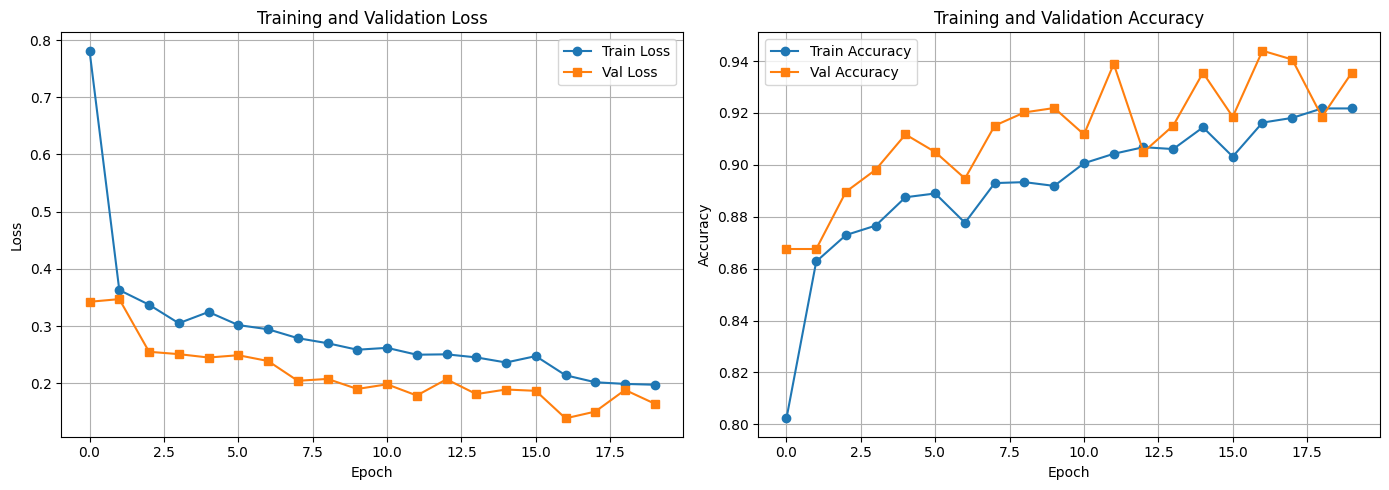

In [10]:
# ----------------------------
# 8. PLOT TRAINING HISTORY
# ----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(train_accs, label='Train Accuracy', marker='o')
axes[1].plot(val_accs, label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [11]:
# ----------------------------
# 9. TEST SET EVALUATION
# ----------------------------
# Load best model
model.load_state_dict(torch.load('best_mold_model.pth'))
model.eval()

all_predictions = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        predictions = (probs > 0.5).astype(int).flatten()
        
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.flatten())

# Calculate metrics
test_acc = np.mean(np.array(all_predictions) == np.array(all_labels))
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
cm = confusion_matrix(all_labels, all_predictions)

print("=" * 50)
print("TEST SET RESULTS")
print("=" * 50)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {2 * (precision * recall) / (precision + recall):.4f}")
print("\nConfusion Matrix:")
print(cm)

TEST SET RESULTS
Test Accuracy: 0.9508
Precision: 0.8913
Recall: 0.8119
F1-Score: 0.8497

Confusion Matrix:
[[478  10]
 [ 19  82]]


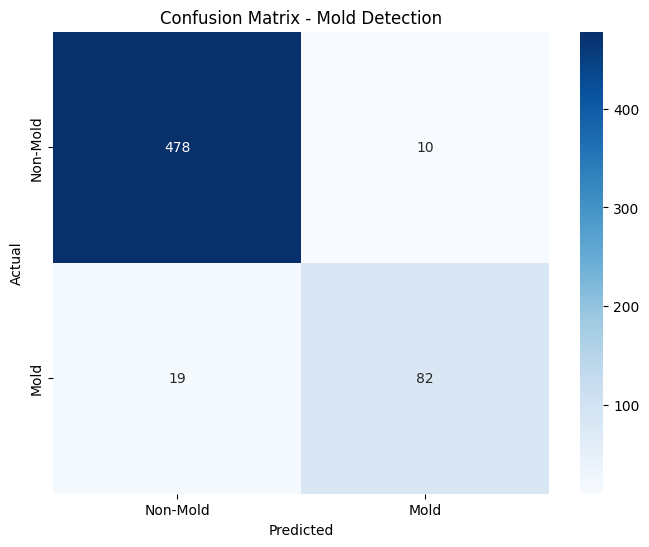

In [12]:
# ----------------------------
# 10. CONFUSION MATRIX VISUALIZATION
# ----------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Mold', 'Mold'], 
            yticklabels=['Non-Mold', 'Mold'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Mold Detection')
plt.show()

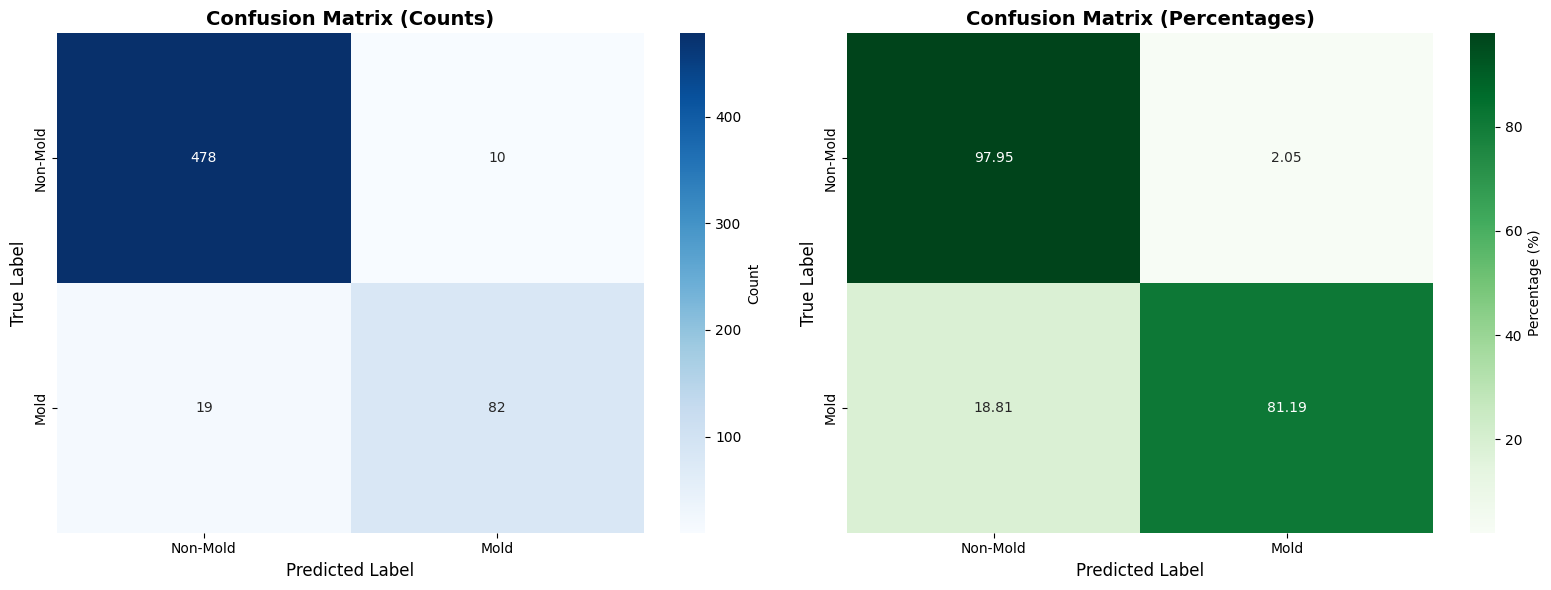


CONFUSION MATRIX BREAKDOWN
True Negatives (TN):   478 - Correctly identified Non-Mold
False Positives (FP):   10 - Non-Mold incorrectly classified as Mold
False Negatives (FN):   19 - Mold incorrectly classified as Non-Mold
True Positives (TP):    82 - Correctly identified Mold

ADDITIONAL METRICS:
Specificity (True Negative Rate): 0.9795
Negative Predictive Value (NPV):  0.9618
False Positive Rate (FPR):        0.0205
False Negative Rate (FNR):        0.1881


In [18]:
# ----------------------------
# 11. DETAILED CONFUSION MATRIX ANALYSIS
# ----------------------------
from sklearn.metrics import classification_report

# Enhanced confusion matrix with percentages
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-Mold', 'Mold'], 
            yticklabels=['Non-Mold', 'Mold'],
            cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Greens', ax=axes[1],
            xticklabels=['Non-Mold', 'Mold'], 
            yticklabels=['Non-Mold', 'Mold'],
            cbar_kws={'label': 'Percentage (%)'})
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Extract confusion matrix values
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*60)
print("CONFUSION MATRIX BREAKDOWN")
print("="*60)
print(f"True Negatives (TN):  {tn:4d} - Correctly identified Non-Mold")
print(f"False Positives (FP): {fp:4d} - Non-Mold incorrectly classified as Mold")
print(f"False Negatives (FN): {fn:4d} - Mold incorrectly classified as Non-Mold")
print(f"True Positives (TP):  {tp:4d} - Correctly identified Mold")
print("="*60)

# Calculate additional metrics
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

print("\nADDITIONAL METRICS:")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Negative Predictive Value (NPV):  {npv:.4f}")
print(f"False Positive Rate (FPR):        {fpr:.4f}")
print(f"False Negative Rate (FNR):        {fnr:.4f}")
print("="*60)


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Non-Mold     0.9618    0.9795    0.9706       488
        Mold     0.8913    0.8119    0.8497       101

    accuracy                         0.9508       589
   macro avg     0.9265    0.8957    0.9101       589
weighted avg     0.9497    0.9508    0.9498       589



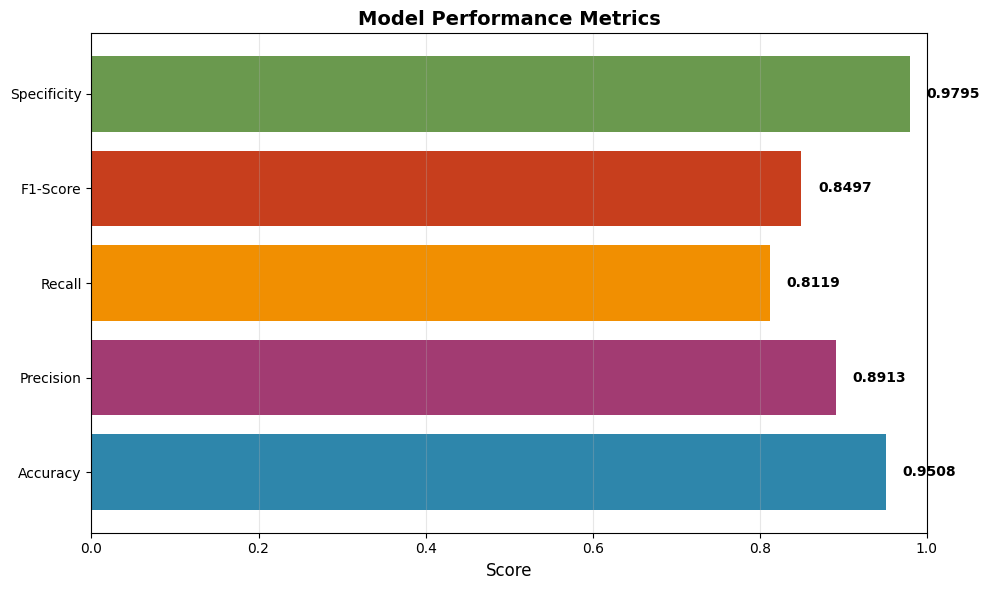

In [19]:
# ----------------------------
# 12. CLASSIFICATION REPORT
# ----------------------------
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, all_predictions, 
                          target_names=['Non-Mold', 'Mold'],
                          digits=4))

# Visual representation of metrics
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity'],
    'Score': [
        test_acc,
        precision,
        recall,
        2 * (precision * recall) / (precision + recall),
        specificity
    ]
}

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(metrics_data['Metric'], metrics_data['Score'], color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E'])
ax.set_xlabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1)
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, metrics_data['Score'])):
    ax.text(score + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{score:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

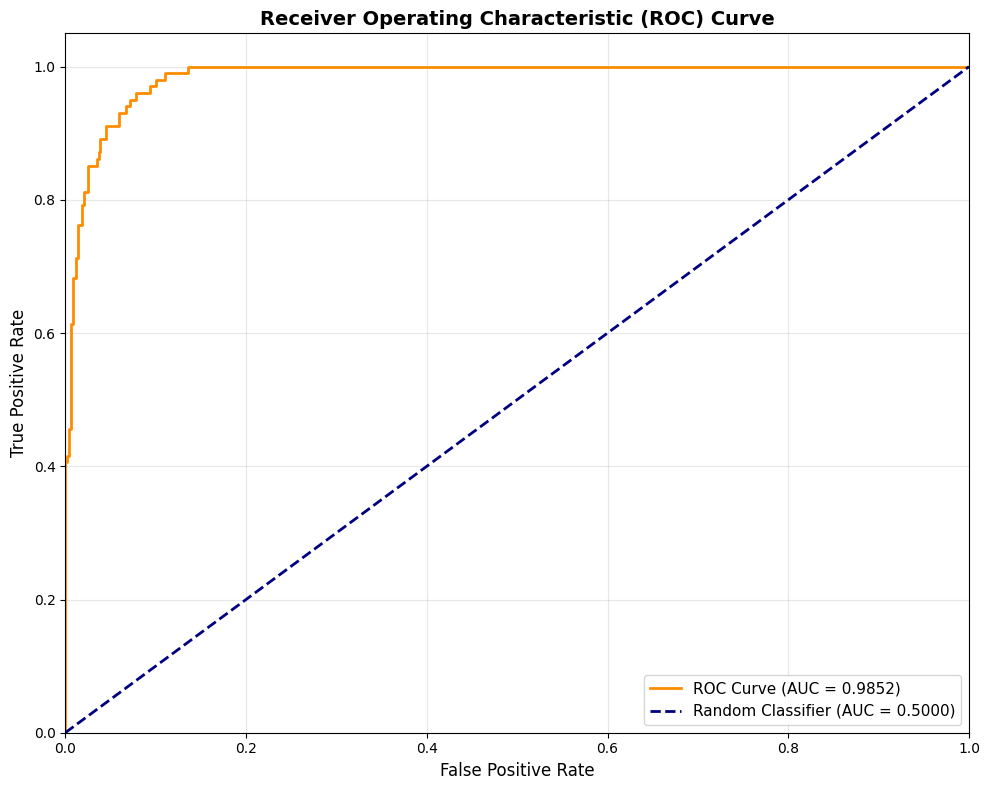


Area Under the Curve (AUC): 0.9852

Interpretation:
- AUC = 1.0: Perfect classifier
- AUC = 0.9-1.0: Excellent classifier
- AUC = 0.8-0.9: Good classifier
- AUC = 0.7-0.8: Fair classifier
- AUC = 0.5: Random classifier (no discrimination ability)


In [15]:
# ----------------------------
# 13. ROC CURVE AND AUC SCORE
# ----------------------------
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr_roc, tpr_roc, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr_roc, tpr_roc)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nArea Under the Curve (AUC): {roc_auc:.4f}")
print("\nInterpretation:")
print("- AUC = 1.0: Perfect classifier")
print("- AUC = 0.9-1.0: Excellent classifier")
print("- AUC = 0.8-0.9: Good classifier")
print("- AUC = 0.7-0.8: Fair classifier")
print("- AUC = 0.5: Random classifier (no discrimination ability)")

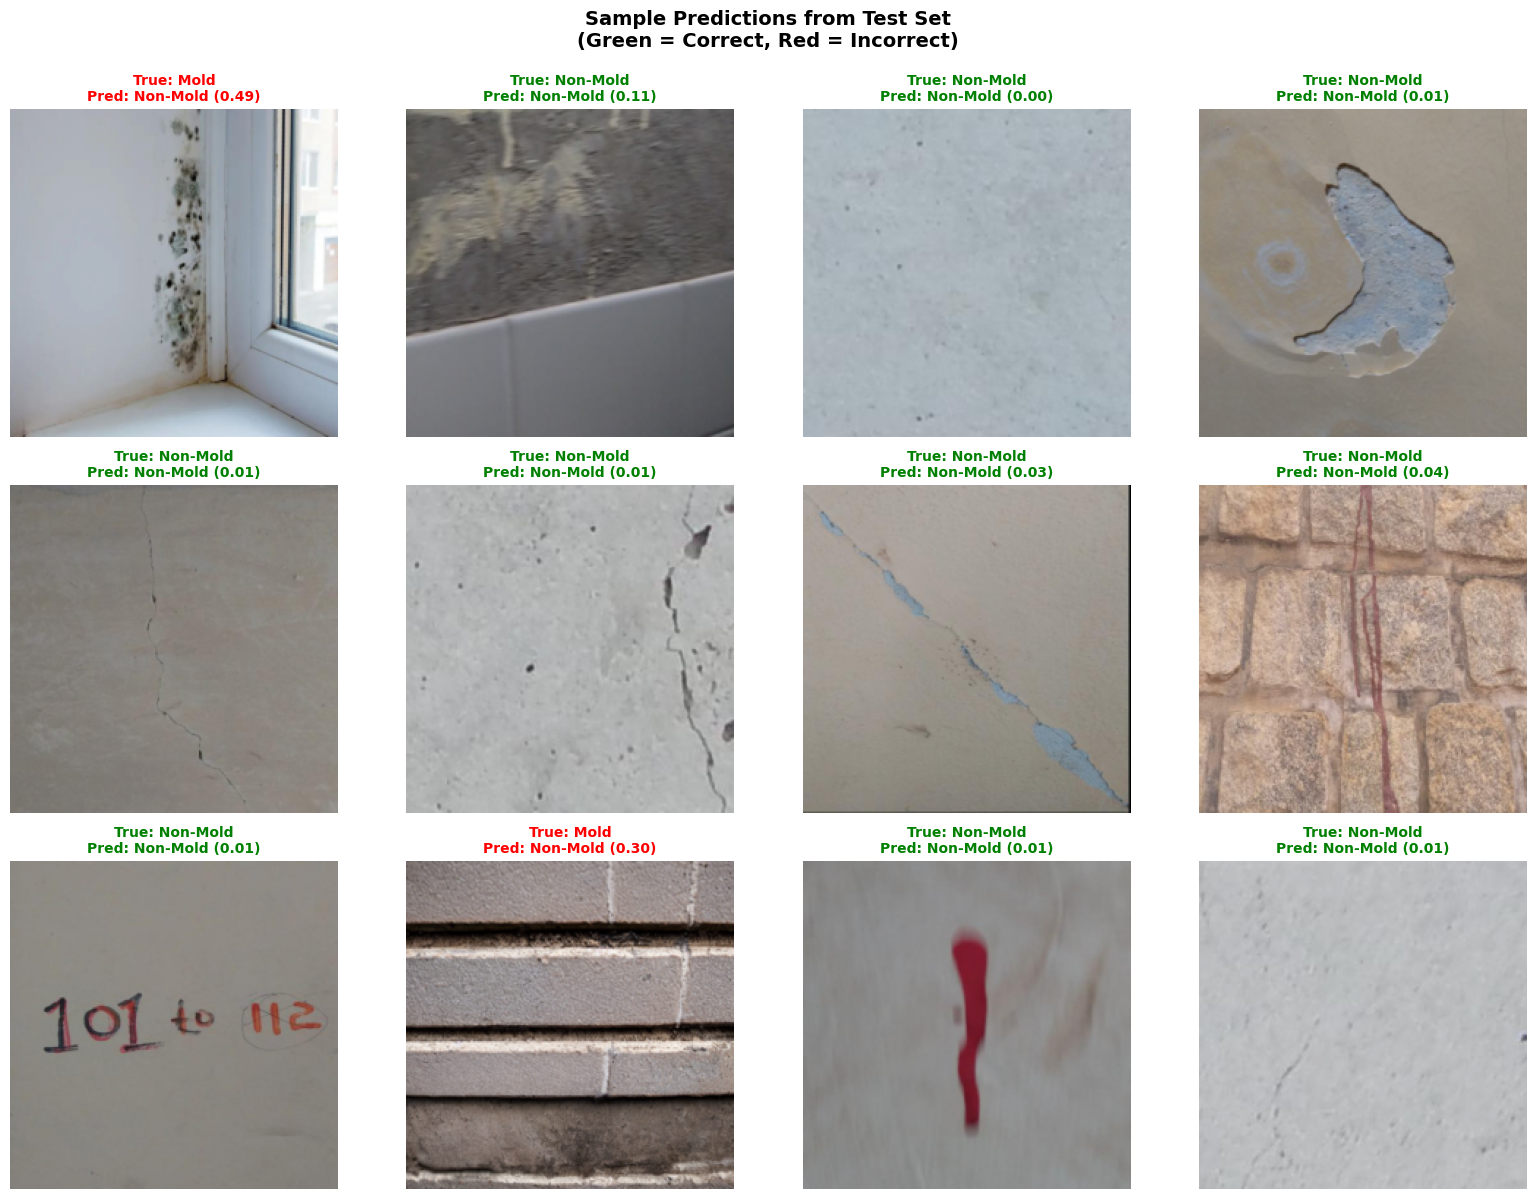

In [16]:
# ----------------------------
# 14. SAMPLE PREDICTIONS VISUALIZATION
# ----------------------------
# Get some test samples for visualization
test_dataset_full = BuildingDataset(DATASET_PATH, transform=val_tfms)
sample_indices = np.random.choice(test_idx, size=min(12, len(test_idx)), replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

model.eval()
with torch.no_grad():
    for idx, sample_idx in enumerate(sample_indices):
        if idx >= 12:
            break
            
        image, true_label = test_dataset_full[sample_idx]
        image_display = image.permute(1, 2, 0).numpy()
        
        # Denormalize for display
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_display = std * image_display + mean
        image_display = np.clip(image_display, 0, 1)
        
        # Get prediction
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)
        prob = torch.sigmoid(output).cpu().item()
        pred_label = 1 if prob > 0.5 else 0
        
        # Plot
        axes[idx].imshow(image_display)
        axes[idx].axis('off')
        
        true_class = "Mold" if true_label == 1 else "Non-Mold"
        pred_class = "Mold" if pred_label == 1 else "Non-Mold"
        color = 'green' if pred_label == true_label else 'red'
        
        title = f"True: {true_class}\nPred: {pred_class} ({prob:.2f})"
        axes[idx].set_title(title, fontsize=10, fontweight='bold', color=color)

plt.suptitle('Sample Predictions from Test Set\n(Green = Correct, Red = Incorrect)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [17]:
# ----------------------------
# 15. RESULTS INTERPRETATION & INSIGHTS
# ----------------------------
print("="*70)
print("MODEL PERFORMANCE SUMMARY & INTERPRETATION")
print("="*70)

print("\n📊 OVERALL PERFORMANCE:")
print(f"   • Test Accuracy: {test_acc*100:.2f}%")
print(f"   • AUC Score: {roc_auc:.4f}")

print("\n🎯 MOLD DETECTION (Positive Class):")
print(f"   • Precision: {precision:.4f} - Of all predicted molds, {precision*100:.2f}% were actual molds")
print(f"   • Recall: {recall:.4f} - Detected {recall*100:.2f}% of all actual mold cases")
print(f"   • F1-Score: {2*(precision*recall)/(precision+recall):.4f} - Balanced measure")

print("\n🏠 NON-MOLD DETECTION (Negative Class):")
print(f"   • Specificity: {specificity:.4f} - Correctly identified {specificity*100:.2f}% of non-mold cases")
print(f"   • NPV: {npv:.4f} - Of all predicted non-molds, {npv*100:.2f}% were actually non-molds")

print("\n⚠️  ERROR ANALYSIS:")
print(f"   • False Positives: {fp} cases - Non-mold incorrectly flagged as mold")
print(f"   • False Negatives: {fn} cases - Mold missed by the detector")
print(f"   • False Positive Rate: {fpr*100:.2f}% - Risk of false alarms")
print(f"   • False Negative Rate: {fnr*100:.2f}% - Risk of missing mold")

print("\n💡 KEY INSIGHTS:")
if test_acc >= 0.9:
    print("   ✓ Excellent overall accuracy achieved")
elif test_acc >= 0.8:
    print("   ✓ Good overall accuracy achieved")
else:
    print("   ⚠ Model accuracy could be improved")

if recall >= 0.9:
    print("   ✓ High recall - model catches most mold cases")
elif recall >= 0.8:
    print("   ✓ Good recall - model catches majority of mold cases")
else:
    print("   ⚠ Low recall - model misses significant mold cases")

if precision >= 0.9:
    print("   ✓ High precision - few false alarms")
elif precision >= 0.8:
    print("   ✓ Good precision - acceptable false alarm rate")
else:
    print("   ⚠ Low precision - high false alarm rate")

if fnr < 0.1:
    print("   ✓ Very low false negative rate - reliable detection")
elif fnr < 0.2:
    print("   ✓ Low false negative rate - good safety margin")
else:
    print("   ⚠ High false negative rate - safety concern")

print("\n" + "="*70)
print("RECOMMENDATION:")
if test_acc >= 0.9 and recall >= 0.85 and precision >= 0.85:
    print("✓ Model is ready for deployment with monitoring")
elif test_acc >= 0.8:
    print("⚠ Model shows good performance but may need fine-tuning")
else:
    print("⚠ Model needs improvement before deployment")
print("="*70)

MODEL PERFORMANCE SUMMARY & INTERPRETATION

📊 OVERALL PERFORMANCE:
   • Test Accuracy: 95.08%
   • AUC Score: 0.9852

🎯 MOLD DETECTION (Positive Class):
   • Precision: 0.8913 - Of all predicted molds, 89.13% were actual molds
   • Recall: 0.8119 - Detected 81.19% of all actual mold cases
   • F1-Score: 0.8497 - Balanced measure

🏠 NON-MOLD DETECTION (Negative Class):
   • Specificity: 0.9795 - Correctly identified 97.95% of non-mold cases
   • NPV: 0.9618 - Of all predicted non-molds, 96.18% were actually non-molds

⚠️  ERROR ANALYSIS:
   • False Positives: 10 cases - Non-mold incorrectly flagged as mold
   • False Negatives: 19 cases - Mold missed by the detector
   • False Positive Rate: 2.05% - Risk of false alarms
   • False Negative Rate: 18.81% - Risk of missing mold

💡 KEY INSIGHTS:
   ✓ Excellent overall accuracy achieved
   ✓ Good recall - model catches majority of mold cases
   ✓ Good precision - acceptable false alarm rate
   ✓ Low false negative rate - good safety margin

